# **Project Board: ESP32 Image Recognition for Terrain Classification**

## **1. Import Dataset**
- **Details**: Gather and organize image data.
- **Tasks**:
  - Source image data relevant to different terrain types.
  - Convert images into a format compatible with PyTorch (e.g., tensors).
  - Pull data from drive using png
  - Determine and standardize image resolution (e.g., resize if needed).

## **2. Data Preprocessing**
- **Tasks**:
  - Normalize image pixel values.
  - Apply data augmentation techniques (e.g., rotations, flips) to increase dataset variability.
  -- torchvision.transforms can be used in a DataLoader pipeline to apply augmentations such as random rotations, flips, or color jittering directly when loading the batch so maybe just do it dynamically
  - Split data randomly into training, validation, and test sets.

## **3. Model Architecture**
- **Framework**: PyTorch
- **Tasks**:
  - Define the architecture of the neural network (e.g., CNN for image recognition).
  - Choose the number of layers and nodes based on complexity.
  - Integrate dropout layers if necessary to prevent overfitting.

## **4. Loss Function**
- **Details**:
  - Select a suitable loss function, such as `CrossEntropyLoss` for classification tasks.
- **Tasks**:
  - Research and set up the initial loss function.
  - Fine-tune or consider alternatives if performance needs improvement.

## **5. Training**
- **Framework**: PyTorch
- **Optimizer**: Adam optimizer
- **Tasks**:
  - Implement training loop with forward pass, backward pass, and parameter updates.
  - Set up early stopping criteria or callbacks for monitoring validation loss.
  - Log performance metrics (e.g., loss and accuracy at each epoch).

## **6. Evaluation and Testing**
- **Tasks**:
  - Evaluate model on the test dataset.
  - Plot model performance
  - Create confusion matrix and other relevant metrics (e.g., precision, recall).
  - Fine-tune the model as needed based on results.

## **7. Deployment**
- **Tasks**:
  - Test the model with real-time ESP32 input.
  - Optimize the model for deployment, considering the constraints of the ESP32. Such as how often we try to judge an image
  - Convert the PyTorch model to a lightweight format compatible with the device (e.g., use ONNX or TensorFlow Lite). IDK about this tbh?

## **8. Documentation**
- **Tasks**:
  - Write clear documentation for data collection, training process, and model architecture.



## **1. Import Dataset**



In [1]:
import os
from glob import glob
from google.colab import drive
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')
folder_path = "/content/drive/My Drive/full_clean"
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpg')]
print(f"Found {len(image_files)} images.")


# shared_drives_path = "/content/drive/Shared drives/"
# print(os.listdir(shared_drives_path))

Mounted at /content/drive
Found 1 images.


In [2]:
dirt = "/dirt"; grassy = "/grassy"; rocky = "/rocky"; sandy = "/sandy"

#image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpg')]
dirt_image_files = glob(folder_path + dirt + '/*.png'); grass_image_files = glob(folder_path + grassy + '/*.png'); rocky_image_files = glob(folder_path + rocky + '/*.png'); sandy_image_files = glob(folder_path + sandy + '/*.png')

print(f"Dirt Images: {len(dirt_image_files)}"); print(f"Grass Images: {len(grass_image_files)}"); print(f"Rocky Images: {len(rocky_image_files)}"); print(f"Sandy Images: {len(sandy_image_files)}")

example_dirt_img = Image.open(dirt_image_files[0])
example_grass_img = Image.open(grass_image_files[0])
example_rocky_img = Image.open(rocky_image_files[0])
example_sandy_img = Image.open(sandy_image_files[0])

print(f"Dirt Image Size: {example_dirt_img.size}")


# Combine all image files and assign labels manually
all_image_files = dirt_image_files + grass_image_files + rocky_image_files + sandy_image_files
labels = [0] * len(dirt_image_files) + [1] * len(grass_image_files) + [2] * len(rocky_image_files) + [3] * len(sandy_image_files)

# Define class names
class_names = ['dirt', 'grass', 'rocky', 'sandy']

# print(f"Labels: {labels}")
print(f"Length of labels: {len(labels)}")
assert len(all_image_files) == len(labels), "Number of image files and labels should be the same."

Dirt Images: 1545
Grass Images: 3000
Rocky Images: 1990
Sandy Images: 2280
Dirt Image Size: (1000, 563)
Length of labels: 8815


In [3]:
#Mini model
mini = True
if mini:
  transform = transforms.Compose([
      transforms.Resize((128, 64)),  # Resize images
      transforms.ToTensor()          # Convert to tensor
  ])
else:
  transform = transforms.Compose([
      transforms.Resize((512, 256)),  # Resize images
      transforms.ToTensor()          # Convert to tensor
  ])

class CustomImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = Image.open(img_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Get corresponding label
        label = self.labels[idx]

        return image, label

In [4]:
assert len(all_image_files) == len(labels), "Number of image files and labels should be the same."
train_image_files, val_image_files, train_labels, val_labels = train_test_split(all_image_files, labels, test_size=0.2, random_state=42)
# train_image_files, test_image_files, train_labels, test_labels = train_test_split(
#        all_image_files, labels, test_size=0.2, random_state=42
#    )
# train_image_files, val_image_files, train_labels, val_labels = train_test_split(
#        train_image_files, train_labels, test_size=0.4, random_state=42
#    )

# Instantiate the dataset
dataset = CustomImageDataset(image_files=all_image_files, labels=labels, transform=transform)

# Create custom datasets for training and validation
train_dataset = CustomImageDataset(image_files=train_image_files, labels=train_labels, transform=transform)
# test_dataset = CustomImageDataset(image_files=test_image_files, labels=test_labels, transform=transform)
val_dataset = CustomImageDataset(image_files=val_image_files, labels=val_labels, transform=transform)

# Create DataLoader for both training and validation
batch_size = 16
print(f"Batch size: {batch_size}")
num_workers = 8
print(f"Number of workers: {num_workers}")
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)


# Create a DataLoader for batching # Defunct
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example: Get one batch from DataLoader
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

print(f"Batch of images shape: {images.shape}")  # Should print (32, 3, 512, 256)
print(f"Batch of labels: {labels}")  # Should print tensor of labels for the batch


Batch size: 16
Number of workers: 8


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch of images shape: torch.Size([16, 3, 128, 64])
Batch of labels: tensor([1, 1, 0, 1, 2, 0, 3, 1, 3, 2, 2, 1, 2, 2, 0, 3])


In [5]:
#Show images
shouldShow = False
if shouldShow:
  plt.imshow(example_dirt_img)
  plt.axis('off')
  plt.show()
  plt.imshow(example_grass_img)
  plt.axis('off')
  plt.show()
  plt.imshow(example_rocky_img)
  plt.axis('off')
  plt.show()
  plt.imshow(example_sandy_img)
  plt.axis('off')
  plt.show()

## **2. Data Preprocessing**


## **5. Training**


In [6]:
# Model
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        #First convulutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2,stride = 2)

        #Second convulutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        #Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        if mini:
          self.fc1 = nn.Linear(64 * 16 * 8, 512)
        else:
          self.fc1 = nn.Linear(64 * 64 * 32, 512)
        self.fc2 = nn.Linear(512, 4) #Map to our 4 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # if mini:
        #   x = x.view(-1, 64 * 64 * 32) #Flatten to 1d vector for fully connected layer
        # else:
        #   x = x.view(-1, 64 * 64 * 32) #Flatten to 1d vector for fully connected layer
        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNNModel().to('cuda')

print(model)



CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


In [7]:
# Optimzer

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU found'}")

CUDA available: True
GPU Name: Tesla T4


In [8]:
# !nvidia-smi
# !lscpu
# !top -n 1


num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  num_batches = 0
  for images, labels in train_dataloader:
    num_batches += 1
    if num_batches % 25 == 0:
      print(num_batches, end=", ")
    images, labels = images.cuda(), labels.cuda()
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
  train_losses.append(epoch_loss/len(train_dataloader))
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}")

  #Validation
  model.eval()  # Set model to evaluation mode
  val_running_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():  # No gradients needed for validation
      for images, labels in val_dataloader:
          images, labels = images.cuda(), labels.cuda()
          outputs = model(images)
          loss = criterion(outputs, labels)

          val_running_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()

  # Store validation loss for graphing
  val_losses.append(val_running_loss / len(val_dataloader))

  # Print validation statistics
  print(f"Validation Loss: {val_running_loss / len(val_dataloader):.4f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%")



25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, Epoch [1/10], Loss: 0.7359
Validation Loss: 0.4888, Validation Accuracy: 77.65%
25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, Epoch [2/10], Loss: 0.2987
Validation Loss: 0.1484, Validation Accuracy: 95.18%
25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, Epoch [3/10], Loss: 0.1030
Validation Loss: 0.1324, Validation Accuracy: 96.14%
25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, Epoch [4/10], Loss: 0.0802
Validation Loss: 0.0276, Validation Accuracy: 99.32%
25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, Epoch [5/10], Loss: 0.0514
Validation Loss: 0.0216, Validation Accuracy: 99.32%
25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, Epoch [6/10], Loss: 0.0594
Validation Loss: 0.0686, Validation Accuracy: 97.45%
25, 50, 75, 100, 125, 150, 1

## **6. Evaluation and Testing**


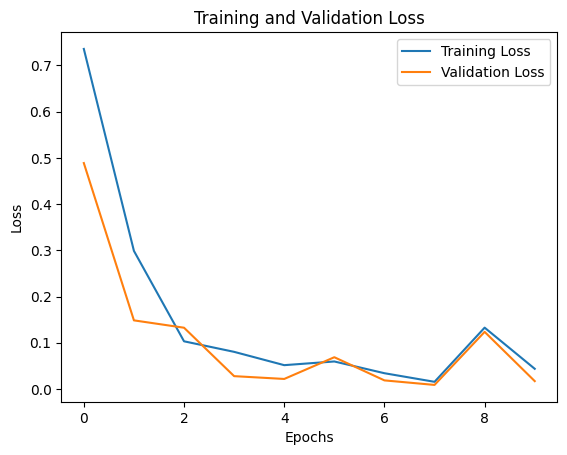

In [9]:
# Plot the training and validation loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()